# Coronavirus Prediction

## Overview

The goal of this project is to investigate Coronavirus and make related predictions in regard to time series modeling. The data is accessed by public APIs. Machine learning and deep learning methods such as ARMA, ARIMA, SARIMAX, Facebook PROPHET, Recurrent Neural Network and Long short-term memory (LSTM) Networks are implemented and evaluated

## Business Understanding

The prediction problem of Coronavirus comes with a significant degree of ambiguity, which is difficult to predict considering the complex circumstances in the real world. While one important task in this project is understanding time series modeling and forecasting related rates for the decision makers to layout some strategies in dealing with covid-19.

## Data Understanding

Data Collection by API

### Import Packages

In [373]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pickle

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')
#import geopandas as gpd
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
# display preferences
register_matplotlib_converters()

### Coronavirus API

https://www.programmableweb.com/api/coronavirus-tracker-rest-api-v20 \
https://covidtracking.com/data/api \
https://cord19.vespa.ai

In [137]:
# Coronavirus Tracker REST API 
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [120]:
data = pd.DataFrame(d['locations'])
data.head()

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,37172386.0,,2021-01-29T19:31:32.703051Z,"{'latitude': '33.93911', 'longitude': '67.7099...","{'confirmed': 54891, 'deaths': 2397, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
1,1,Albania,AL,2866376.0,,2021-01-29T19:31:32.736549Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 75454, 'deaths': 1350, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
2,2,Algeria,DZ,42228429.0,,2021-01-29T19:31:32.766121Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 106610, 'deaths': 2881, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
3,3,Andorra,AD,77006.0,,2021-01-29T19:31:32.796740Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 9779, 'deaths': 100, 'recovered'...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
4,4,Angola,AO,30809762.0,,2021-01-29T19:31:32.826085Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19672, 'deaths': 464, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...


In [ ]:
# pd.DataFrame(d['locations'][249]['timelines']['confirmed']).plot()
# pd.DataFrame(d['locations'][249]['timelines']['deaths']).plot()

In [138]:
data[data['country_code']=='US'].iloc[:,:3]

,id,country,country_code
249,249,US,US


In [235]:
# ts = pd.DataFrame(d['locations'][249]['timelines']['deaths'])
# ts.index = pd.to_datetime(ts.index).date

In [407]:
# The covid tracking project data api 
url = 'https://api.covidtracking.com/v1/us/daily.json'
response = requests.get(url)
dus = response.json()

df = pd.DataFrame(dus[::-1])
df.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20200113,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-13T24:00:00Z,None,0,0,0,0,0,0,0,5672debf187b183735be63f6bd85834ead0047ff
1,20200114,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-14T24:00:00Z,None,0,0,0,0,0,0,0,fe399466a3dfbe0221a18ed5cacb39a3882d72f8
2,20200115,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-15T24:00:00Z,None,0,0,0,0,0,0,0,8a449023413eea473277416e9e30ae126c6af047
3,20200116,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-16T24:00:00Z,None,0,0,0,0,0,0,0,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
4,20200117,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-17T24:00:00Z,None,0,0,0,0,0,0,0,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6


In [389]:
url = 'https://api.covidtracking.com/v1/states/daily.json'
response = requests.get(url)
daily = response.json()
df1 = pd.DataFrame(daily[::-1])
df1.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200113,WA,NaN,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,4b278ad9e69da1c2a818f761c25f10c4bb6bf2a7,0,0,0,0,0,
1,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,84aeea9c6a284b151fdb42a863db3c0aadb651bf,0,0,0,0,0,
2,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,bd1eef4afdffd883e37be1d3f321dc3b0e75f591,0,0,0,0,0,
3,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,d9453d58f00994cff1f81639e95e532d1dd10138,0,0,0,0,0,
4,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,effcc7b17054638471dec2f2a9cdbd3229d92042,0,0,0,0,0,


## Data Preparation

### Exploratory Data Analysis

In [430]:
# df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
# df.set_index('date', inplace=True)
df['mortality'] = np.where(df.positiveIncrease==0, 0, df.deathIncrease/df.positiveIncrease)

(0.0, 0.15)

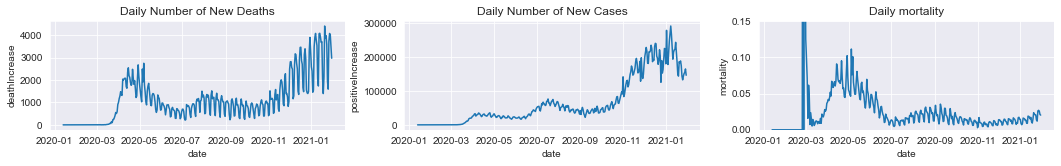

In [472]:
# plot target variables
fig, ax = plt.subplots(1, 3, figsize=(18,2))
sns.lineplot(data=df.deathIncrease, ax=ax[0])
ax[0].set_title('Daily Number of New Deaths')
sns.lineplot(data=df.positiveIncrease, ax=ax[1])
ax[1].set_title('Daily Number of New Cases')
sns.lineplot(data=df.mortality, ax=ax[2])
ax[2].set_title('Daily mortality')
ax[2].set_ylim(0, 0.15)
# plt.subplots_adjust(hspace = 0.5)

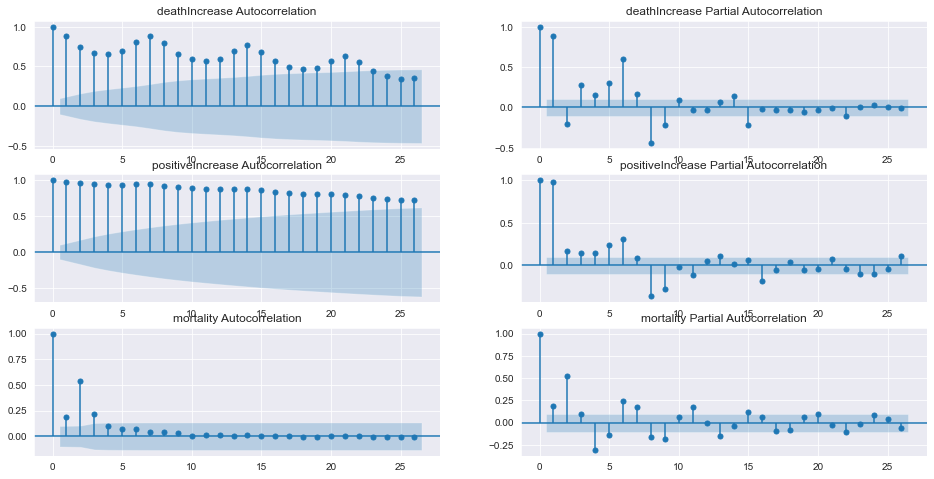

In [474]:
# Plot deaths ACF & PACF
fig, ax = plt.subplots(3, 2, figsize=(16,8))
plot_acf(df.deathIncrease, title='deathIncrease Autocorrelation', ax=ax[0][0]);
plot_pacf(df.deathIncrease, title='deathIncrease Partial Autocorrelation', ax=ax[0][1]);
plot_acf(df.positiveIncrease, title='positiveIncrease Autocorrelation', ax=ax[1][0]);
plot_pacf(df.positiveIncrease, title='positiveIncrease Partial Autocorrelation', ax=ax[1][1]);
plot_acf(df.mortality, title='mortality Autocorrelation', ax=ax[2][0]);
plot_pacf(df.mortality, title='mortality Partial Autocorrelation', ax=ax[2][1]);
#plt.savefig('images/acf.jpeg', format='jpeg')

### Dickey-Fuller Test

In [182]:
def stationarity_check(TS):       
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)     
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()    
    # Plot rolling statistics:
    #fig = plt.figure(figsize=(12,6))
    orig = sns.lineplot(data=TS, palette=['blue'],label='Original')
    mean = sns.lineplot(data=roll_mean, palette=['red'], label='Rolling Mean')
    std = sns.lineplot(data=roll_std, palette=['black'], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])                   
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [436]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.deathIncrease)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

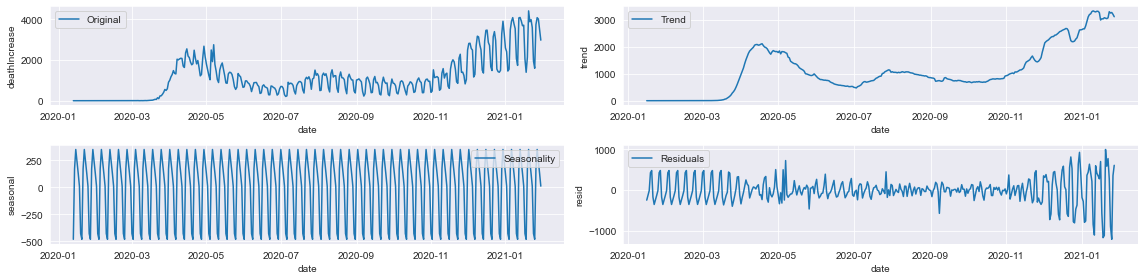

In [437]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.deathIncrease, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

In [175]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.positiveIncrease)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

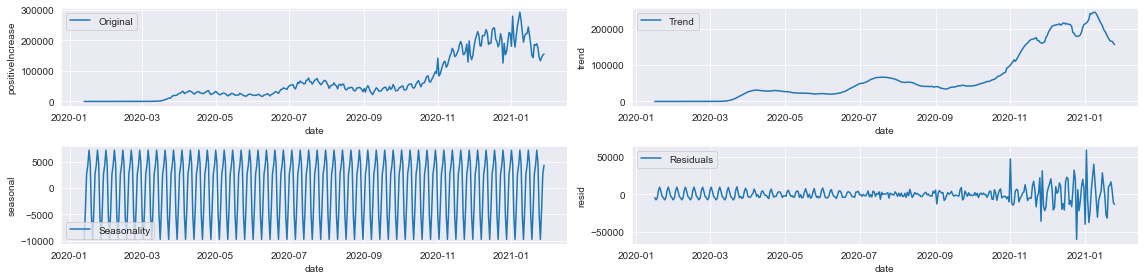

In [176]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.positiveIncrease, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

In [434]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.mortality)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

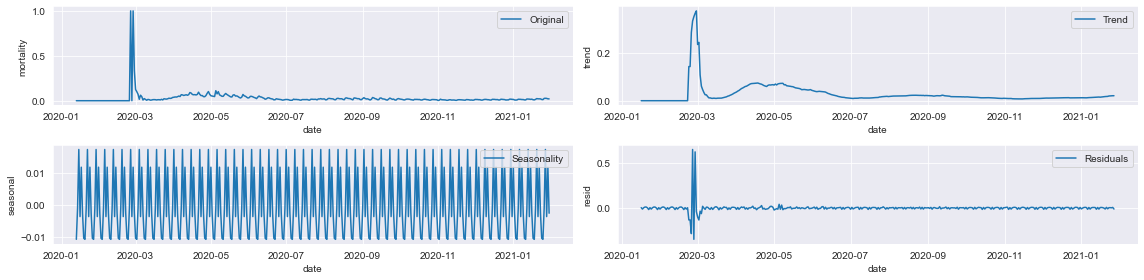

In [435]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.mortality, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

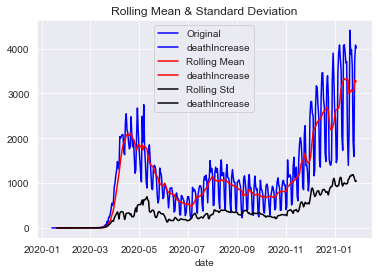

Results of Dickey-Fuller Test: 

Test Statistic                  -0.951804
p-value                          0.770434
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64


In [183]:
stationarity_check(df.deathIncrease)

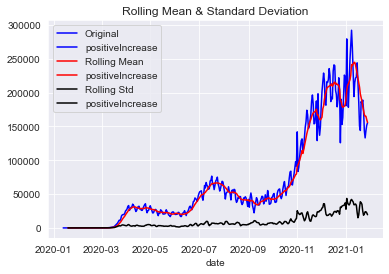

Results of Dickey-Fuller Test: 

Test Statistic                  -0.888697
p-value                          0.791672
#Lags Used                      15.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [184]:
stationarity_check(df.positiveIncrease)

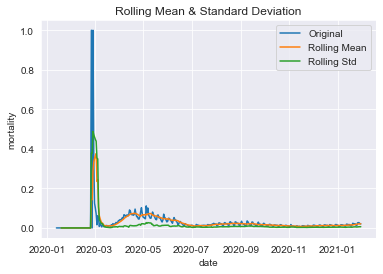

Results of Dickey-Fuller Test: 

Test Statistic                  -4.228583
p-value                          0.000589
#Lags Used                      14.000000
Number of Observations Used    369.000000
Critical Value (1%)             -3.448197
Critical Value (5%)             -2.869405
Critical Value (10%)            -2.570960
dtype: float64


In [438]:
stationarity_check(df.mortality)

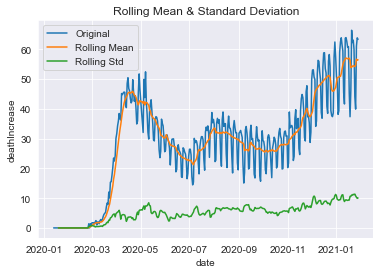

Results of Dickey-Fuller Test: 

Test Statistic                  -1.826656
p-value                          0.367311
#Lags Used                      14.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64


In [188]:
# Plot a square root transform
stationarity_check(np.sqrt(df.deathIncrease))

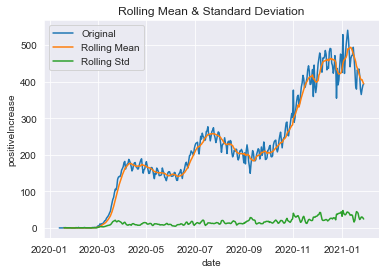

Results of Dickey-Fuller Test: 

Test Statistic                  -1.437175
p-value                          0.564330
#Lags Used                      15.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [189]:
# Plot a square root transform
stationarity_check(np.sqrt(df.positiveIncrease))

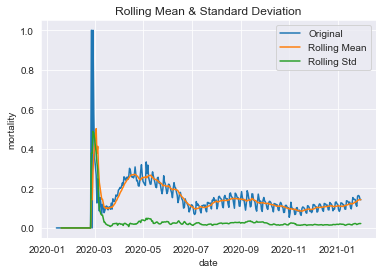

Results of Dickey-Fuller Test: 

Test Statistic                  -3.320902
p-value                          0.013970
#Lags Used                      13.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [440]:
stationarity_check(np.sqrt(df.mortality))

## Modeling

### ARIMA

In [493]:
# construct seperate dataframes per target variable
deaths = pd.DataFrame(df.deathIncrease, index=df.index)

# drop nan values from the start of each target dataframe
deaths.fillna(value=1, inplace=True)

# add one to all values of zero for log transforms
deaths['deathIncrease'] = np.where(deaths.deathIncrease == 0, 1, deaths.deathIncrease)

ARIMA_MODEL = SARIMAX(endog=np.log(deaths),
                      order=(2,1,2),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
print(output.summary().tables[0])
print(output.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:          deathIncrease   No. Observations:                  384
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -175.701
Date:                Mon, 01 Feb 2021   AIC                            361.403
Time:                        00:53:11   BIC                            381.104
Sample:                    01-13-2020   HQIC                           369.220
                         - 01-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7395      0.195      3.787      0.000       0.357       1.122
ar.L2         -0.4350      0.139     -3.138      0.002      -0.707      -0.163
ma.L1         -2.7177    625.946     -0.004      0.9

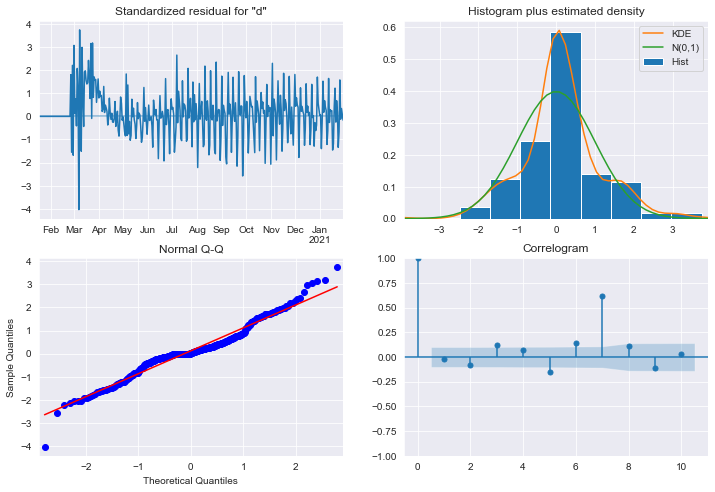

In [500]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [501]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=deaths.index[-100], dynamic=False)
pred_conf = pred.conf_int()

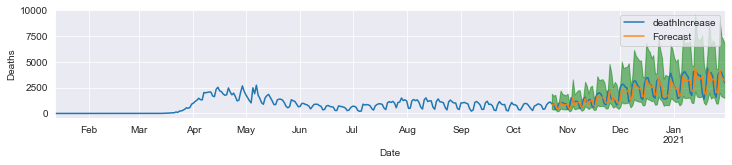

In [502]:
# Plot real vs predicted values along with confidence interval
#plt.rcParams['figure.figsize'] = 12, 2
# Plot observed values
ax = deaths.plot(label='observed')

# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [503]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-100:]

train_mae_death_amx = mean_absolute_error(deaths_forecasted, deaths.deathIncrease[-100:])

The Root Mean Squared Error of our forecasts is 663.59
The Mean Absolute Error of our forecasts is 488.66


In [504]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths.index[-100], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

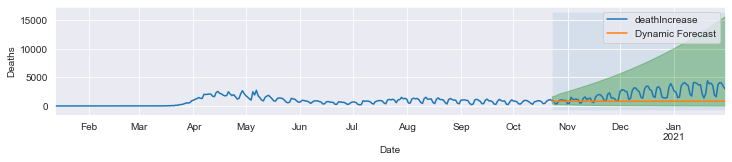

In [505]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths.plot(label='observed')
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths.index[-100], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
# ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1])

plt.legend()
plt.show()

In [512]:
# Extract the predicted and true values of our time series
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)

test_mae_death_amx = mean_absolute_error(deaths_forecasted, deaths.deathIncrease[-100:])

In [507]:
# Get forecast 30 days ahead in future
prediction = output.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

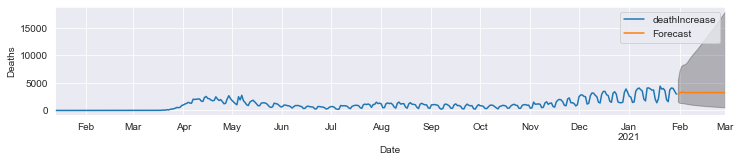

In [508]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed')
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
# ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1]+pd.DateOffset(14))
# plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()
plt.show()

### SARIMAX

#### Grid Search

In [347]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(1, 2)
d = range(1, 2)
q = range(1, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

p = range(0, 2)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [12]:
"""UNCOMMENT CELL BELOW TO RUN GRID SEARCH"""
# # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = SARIMAX(deaths,
#                             order=comb,
#                             seasonal_order=combs,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

# # Find the parameters with minimal AIC value
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # pickle grid parameters
# pickle_out = open("death_grid.pickle","wb")
# pickle.dump(ans_df, pickle_out)
# pickle_out.close()

'UNCOMMENT CELL BELOW TO RUN GRID SEARCH'

In [350]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(deaths,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}7 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# pickle grid parameters
pickle_out = open("death_grid.pickle","wb")
pickle.dump(ans_df, pickle_out)
pickle_out.close()

ARIMA (1, 1, 1) x (0, 0, 0, 7)7 : AIC Calculated =5715.786262663167
ARIMA (1, 1, 1) x (0, 0, 1, 7)7 : AIC Calculated =5429.52635588111
ARIMA (1, 1, 1) x (0, 0, 2, 7)7 : AIC Calculated =5240.645481477315
ARIMA (1, 1, 1) x (0, 1, 0, 7)7 : AIC Calculated =5285.468271009557
ARIMA (1, 1, 1) x (0, 1, 1, 7)7 : AIC Calculated =5091.96156972095
ARIMA (1, 1, 1) x (0, 1, 2, 7)7 : AIC Calculated =5003.383147864051
ARIMA (1, 1, 1) x (1, 0, 0, 7)7 : AIC Calculated =5271.262404011208
ARIMA (1, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =5183.866108266121
ARIMA (1, 1, 1) x (1, 0, 2, 7)7 : AIC Calculated =5122.7319496240325
ARIMA (1, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =5126.283015159015
ARIMA (1, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =5093.950938015188
ARIMA (1, 1, 1) x (1, 1, 2, 7)7 : AIC Calculated =5003.769707684911


In [351]:
# load grid parameters
ans_df = pd.read_pickle('death_grid.pickle')

#### SARIMAX Model

In [487]:
# Check grid search results
ans_df.loc[ans_df['aic'].idxmin()][0], ans_df.loc[ans_df['aic'].idxmin()][1]

((1, 1, 1), (0, 1, 2, 7))

In [488]:
deaths = pd.DataFrame()
deaths['deathIncrease'] = df.deathIncrease
# add one to all values of zero for log transforms
deaths['deathIncrease'] = np.where(deaths.deathIncrease == 0, 1, deaths.deathIncrease)

In [489]:
ARIMA_MODEL = SARIMAX(endog=np.log(deaths),
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0862      0.082     -1.050      0.294      -0.247       0.075
ma.L1         -0.3789      0.076     -4.968      0.000      -0.528      -0.229
ma.S.L7       -0.6229      0.034    -18.306      0.000      -0.690      -0.556
ma.S.L14      -0.0834      0.041     -2.050      0.040      -0.163      -0.004
sigma2         0.0659      0.003     20.058      0.000       0.059       0.072


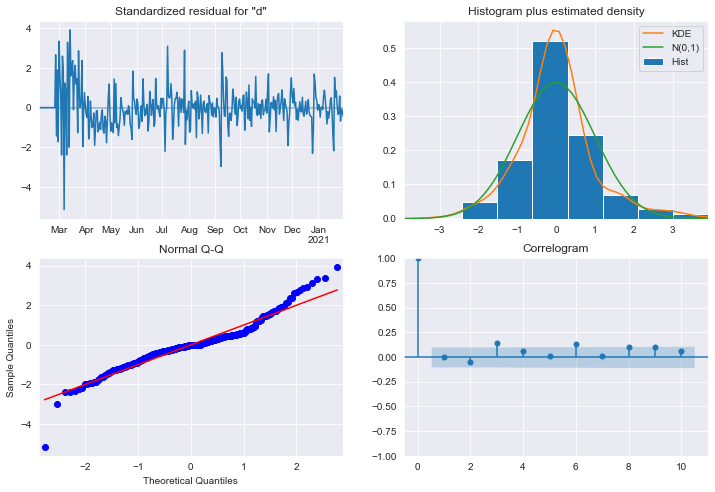

In [491]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8));
#plt.savefig('images/sarimax.jpeg', format='jpeg')

In [415]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=deaths.index[-60], dynamic=False)
pred_conf = pred.conf_int()

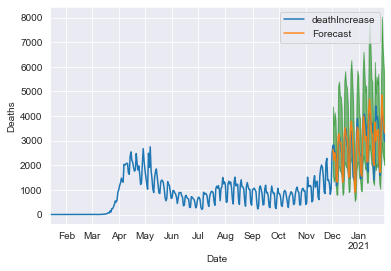

In [416]:
# Plot real vs predicted values along with confidence interval
#plt.rcParams['figure.figsize'] = 12, 2
# Plot observed values
ax = deaths.plot(label='observed')
# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [417]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-60:]

# Compute the mean square error
mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 217981.15
The Root Mean Squared Error of our forecasts is 466.88


In [418]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths.index[-30], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

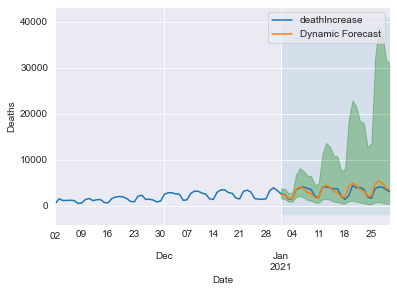

In [475]:
# Plot the dynamic forecast with confidence intervals.
ax = deaths.plot(label='observed')
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths.index[-30], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1])
plt.legend()
#plt.savefig('images/death.jpeg', format='jpeg')

In [421]:
# Extract the predicted and true values of our time series
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)

# Compute the mean square error
mse = ((deaths_forecasted - deaths.deathIncrease[-30:]) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 432070.6
The Root Mean Squared Error of our forecasts is 657.32


In [422]:
# Get forecast 14 days ahead in future
prediction = output.get_forecast(steps=14)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

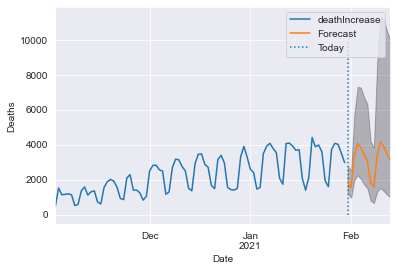

In [423]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed')
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1]+pd.DateOffset(14))
plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()

## Facebook Prophet

In [240]:
# ts.index.name = 'ds'
# ts = ts.reset_index()
# ts = ts.rename(columns={'timeline': 'y'})

In [459]:
fb_death = pd.DataFrame()
fb_death['y'] = df.deathIncrease
fb_death.reset_index(inplace=True)
fb_death = fb_death.rename(columns={'date': 'ds'})

In [460]:
death_train_fb, death_test_fb = fb_death[:-100], fb_death[-100:]

In [461]:
model_death = Prophet(interval_width=0.95)
model_death.fit(death_train_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [462]:
future_dates = model_death.make_future_dataframe(periods=100, freq='D')
forecast_death = model_death.predict(future_dates)
forecast_death.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-13,-250.445505,-1378.728127,275.190702,-250.445505,-250.445505,-288.203318,-288.203318,-288.203318,-288.203318,-288.203318,-288.203318,0.0,0.0,0.0,-538.648823
1,2020-01-14,-236.809793,-968.933713,711.122045,-236.809793,-236.809793,99.495856,99.495856,99.495856,99.495856,99.495856,99.495856,0.0,0.0,0.0,-137.313937
2,2020-01-15,-223.174080,-830.430640,836.037681,-223.174080,-223.174080,204.272333,204.272333,204.272333,204.272333,204.272333,204.272333,0.0,0.0,0.0,-18.901747
3,2020-01-16,-209.538368,-826.836279,735.547415,-209.538368,-209.538368,158.946327,158.946327,158.946327,158.946327,158.946327,158.946327,0.0,0.0,0.0,-50.592040
4,2020-01-17,-195.902655,-911.932814,751.408990,-195.902655,-195.902655,98.899987,98.899987,98.899987,98.899987,98.899987,98.899987,0.0,0.0,0.0,-97.002668


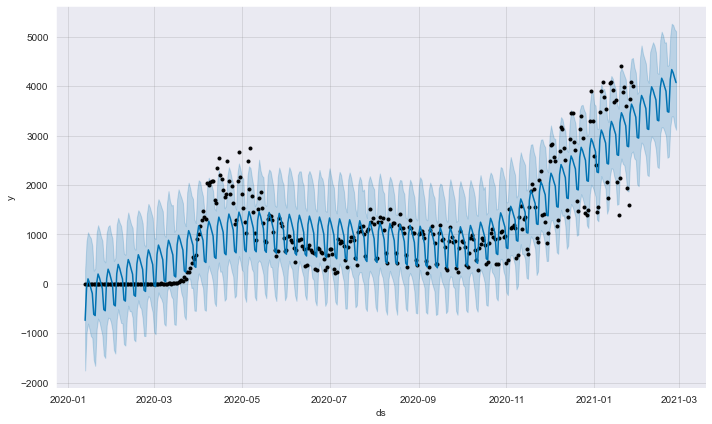

In [254]:
model_death.plot(forecast_death, uncertainty=True);

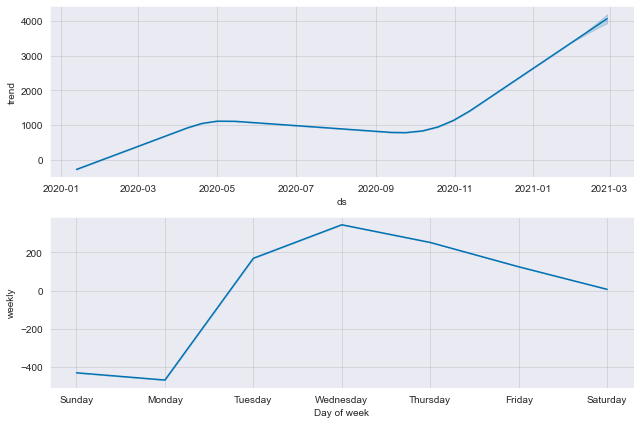

In [258]:
model_death.plot_components(forecast_death);

In [464]:
fb_mortality = pd.DataFrame()
fb_mortality['y'] = df.mortality
fb_mortality.reset_index(inplace=True)
fb_mortality = fb_mortality.rename(columns={'date': 'ds'})

In [465]:
mortality_train_fb, mortality_test_fb = fb_mortality[:-100], fb_mortality[-100:]

In [466]:
model_mortality = Prophet(interval_width=0.95)
model_mortality.fit(mortality_train_fb)

forecast_mortality = model_mortality.predict(future_dates)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## LSTM (long short-term memory) Networks

In [313]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [314]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [333]:
df_lstm = pd.DataFrame()
df_lstm['death'] = df.deathIncrease

In [334]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [335]:
train, test = dataset[:-100], dataset[-100:]

In [336]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [337]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [340]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [341]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

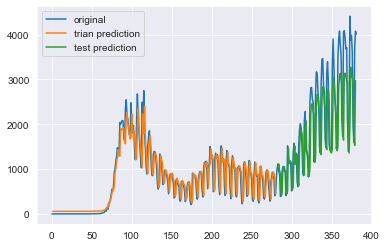

In [477]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(trainPredictPlot,label='trian prediction')
plt.plot(testPredictPlot,label='test prediction')
plt.legend()
#plt.savefig('images/lstm.jpeg', format='jpeg')

In [ ]:
df_lstm = pd.DataFrame()
df_lstm['death'] = df.deathIncrease

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [ ]:
train, test = dataset[:-100], dataset[-100:]

## Evaluation

### metrics in ARIMA

In [515]:
# Compute the mean square error
arima_train_rmse = mean_squared_error(deaths_forecasted, deaths_truth.deathIncrease, squared=False)
arima_test_rmse = mean_squared_error(deaths_forecasted, deaths.deathIncrease[-100:], squared=False)
# Compute the mean absolute error
train_mae_death_amx =  mean_absolute_error(deaths_forecasted, deaths_truth.deathIncrease)
test_mae_death_amx = mean_absolute_error(deaths_forecasted, deaths.deathIncrease[-100:])

print('The training RMSE of our forecasts is {}'.format(round(arima_train_rmse, 2)))
print('The test RMSE of our forecasts is {}'.format(round(arima_test_rmse, 2)))
print('The training MAE of our forecasts is {}'.format(round(train_mae_death_amx, 2)))
print('The test MAE of our forecasts is {}'.format(round(test_mae_death_amx, 2)))

The training RMSE of our forecasts is 1736.8
The test RMSE of our forecasts is 1736.8
The training MAE of our forecasts is 1369.38
The test MAE of our forecasts is 1369.38


### metrics in SARIMAX

In [473]:
# calculate root mean squared error
train_rmse_death_smx = mean_squared_error(np.exp(pred.predicted_mean), deaths.deathIncrease[-60:], squared=False)
train_mae_death_smx = mean_absolute_error(np.exp(pred.predicted_mean), deaths.deathIncrease[-60:])
# calculate mean absolute error
test_rmse_death_smx = mean_squared_error(deaths_forecasted[-30:], deaths.deathIncrease[-30:], squared=False)
test_mae_death_smx = mean_absolute_error(deaths_forecasted[-30:], deaths.deathIncrease[-30:])

print('The Training Root Mean Squared Error of our forecasts is {}'.format(round(train_rmse_death_smx, 2)))
print('The Testing Root Mean Squared Error of our forecasts is {}'.format(round(test_rmse_death_smx, 2)))
print('The Training Mean Absolute Error of our forecasts is {}'.format(round(train_mae_death_smx, 2)))
print('The Testing Mean Absolute Error of our forecasts is {}'.format(round(test_mae_death_smx, 2)))

The Training Root Mean Squared Error of our forecasts is 466.88
The Testing Root Mean Squared Error of our forecasts is 657.32
The Training Mean Absolute Error of our forecasts is 338.22
The Testing Mean Absolute Error of our forecasts is 486.73


### metrics in Facebook Prophet

In [305]:
# calculate root mean squared error
train_rmse_death_fb = mean_squared_error(death_train_fb['y'], forecast_death['yhat'][:-100], squared=False)
test_rmse_death_fb = mean_squared_error(death_test_fb['y'], forecast_death['yhat'][-100:], squared=False)
print('Facebook Prophet deathIncrease train RMSE: {:.2f}'.format(train_rmse_death_fb))
print('Facebook Prophet deathIncrease test RMSE: {:.2f}'.format(test_rmse_death_fb))
# calculate mean absolute error
train_mae_death_fb = mean_absolute_error(death_train_fb['y'], forecast_death['yhat'][:-100])
test_mae_death_fb = mean_absolute_error(death_test_fb['y'], forecast_death['yhat'][-100:])
print('Facebook Prophet deathIncrease train MAE: {:.2f}'.format(train_mae_death_fb))
print('Facebook Prophet deathIncrease test MAE: {:.2f}'.format(test_mae_death_fb))

Facebook Prophet deathIncrease train RMSE: 432.03
Facebook Prophet deathIncrease test RMSE: 1929.95
Facebook Prophet deathIncrease train MAE: 321.32
Facebook Prophet deathIncrease test MAE: 1579.82


In [469]:
# calculate root mean squared error
train_rmse_mortality_fb = mean_squared_error(mortality_train_fb['y'], forecast_mortality['yhat'][:-100], squared=False)
test_rmse_mortality_fb = mean_squared_error(mortality_test_fb['y'], forecast_mortality['yhat'][-100:], squared=False)
print('Facebook Prophet mortality train RMSE: {:.4f}'.format(train_rmse_mortality_fb))
print('Facebook Prophet mortality test RMSE: {:.4f}'.format(test_rmse_mortality_fb))
# calculate mean absolute error
train_mae_mortality_fb = mean_absolute_error(mortality_train_fb['y'], forecast_mortality['yhat'][:-100])
test_mae_mortality_fb = mean_absolute_error(mortality_test_fb['y'], forecast_mortality['yhat'][-100:])
print('Facebook Prophet mortality train MAE: {:.4f}'.format(train_mae_mortality_fb))
print('Facebook Prophet mortality test MAE: {:.4f}'.format(test_mae_mortality_fb))

Facebook Prophet mortality train RMSE: 0.0848
Facebook Prophet mortality test RMSE: 0.0173
Facebook Prophet mortality train MAE: 0.0277
Facebook Prophet mortality test MAE: 0.0150


### metrics in LSTM Networks

In [343]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks deathIncrease train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks deathIncrease test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks deathIncrease train MAE: {:.2f}'.format(trainScore_mae))
print('LSTM Networks deathIncrease test MAE: {:.2f}'.format(testScore_mae))

LSTM Networks deathIncrease train RMSE: 275.27
LSTM Networks deathIncrease test RMSE: 788.28
LSTM Networks deathIncrease train MAE: 183.45
LSTM Networks deathIncrease test MAE: 563.24


## Conclusion

1. LSTM Networks serve as the best model for coronavirus prediction with small RMSE and MAE.
2. SARIMAX with opitmized hyperparameters by Gridsearch also work well for the prediction.
3. Due to limited known condtions, it is difficult to make precise predictions.
4. It shows less death and positive cases at weekends and more cases on Monday.